In [1]:
import os
import torch
import pandas as pd
from dotenv import load_dotenv
from module import Model
from helpers import *

/Users/leondomagalski/DecoderAttention/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
token = os.environ.get("HF_TOKEN")

if torch.backends.mps.is_available():
    torch.mps.empty_cache()

## Creating the Model that will be used to generate text

In [3]:
name = "google/gemma-2-2b-it"
model = Model(name, token)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]


## Loading the prompts that will be used to invoke the model

Each prompt has different length, but contains the information about the name that the model will try to extract. The only thing that differs in the prompts is the amount of additional information that has no correclation to the information being extracted (in this case it is fragments from the book "Harry Potter")

In [4]:
data = load_prompts_jsonl("../prompts/prompts.jsonl")
data

[{'prompt_id': 'p1',
  'prompt_len': 123,
  'prompt': 'The supermodels name is goblin master. What is the super models name? Output only the name and nothing else. Just the name.'},
 {'prompt_id': 'p2',
  'prompt_len': 580,
  'prompt': 'The supermodels name is goblin master. And finally, bird-watchers everywhere have reported that the nation’s owls have been behaving very unusually today. Although owls normally hunt at night and are hardly ever seen in daylight, there have been hundreds of sightings of these birds flying in every direction since sunrise. Experts are unable to explain why the owls have suddenly changed their sleeping pattern. ” The newscaster allowed himself a grin. “Most mysterious. And now, over to Jim McGuffin with the weather. Going  Output only the name and nothing else. Just the name.'},
 {'prompt_id': 'p3',
  'prompt_len': 1032,
  'prompt': 'The supermodels name is goblin master. And finally, bird-watchers everywhere have reported that the nation’s owls have been

In [5]:
for i, prompt in enumerate(data):
    print(f"Prompt {i} status: done")
    
    prompt_results = model.invoke_model(prompt["prompt"])
    data[i]["results"] = prompt_results

    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

Prompt 0 status: done
Prompt 1 status: done
Prompt 2 status: done
Prompt 3 status: done
Prompt 4 status: done
Prompt 5 status: done
Prompt 6 status: done


In [6]:
for i, prompt in enumerate(data):
    data[i]["generated_tokens"] = model.get_model_output(data[i]["results"])

## Retrieve Attention

Retrieve the attention at the last deoder layer (26th) for each generation step and for each one of the 8 attention heads the model has. The reusult is a list of DataFrames, where each one represents one attention head

In [7]:
gen_attn = []
pair_lens = []

for prompt in data:
    gen_attention_results, pairs_len = model.gen_attn_all_heads_all_gen_steps(prompt["results"], 25, 8)
    gen_attn.append(gen_attention_results)
    pair_lens.append(pairs_len)

## Retrieve the Attention Tokens

Get the tokens that the model saved during the process of self attention while generating the text

In [8]:
for head in gen_attn[1]:
    print(head["key_token"].unique())
    print("\n\n")

['<bos>' '▁McGu' '<start_of_turn>' 'user' '\n' '<end_of_turn>' 'models'
 '▁super' '▁very' '▁And' '▁name' '.' '▁Although' '-' '’' 'Output'
 '▁himself' '▁master' '▁grin' '▁unable' '▁that' '▁allowed' '▁bird' '▁news'
 'The' '▁finally' '▁pattern' '▁reported' ',' '▁Experts' '▁today' '▁every'
 '▁is' 'caster' '▁owls' '▁birds' '▁with' '▁normally' '▁to' '▁else' '▁over'
 '▁everywhere' '▁behaving' '▁since' '▁hundreds' '▁why' '▁goblin'
 'watchers' '▁of' '▁and' '▁Just' '▁The' '▁now' '▁direction' '▁are' '▁the'
 '▁unusually' '▁explain' '▁Jim' '▁”' '▁sunrise' '▁weather' '▁night'
 '▁been' '▁“' '▁in' '▁at' '▁there' '▁hunt' '▁Going' '▁have' '▁a'
 '▁nothing' '▁nation' 'model' 'ffin' '▁only' '▁sightings' '▁changed'
 '▁mysterious' '▁hardly' '▁seen' 'Most' '▁▁' '▁flying' '▁these' '▁ever'
 '▁daylight' '▁sleeping' 's' '▁suddenly' '▁their' 'context[124]'
 'context[125]' 'context[126]' 'context[127]' 'context[128]'
 'context[129]' 'context[130]' 'context[131]' 'context[132]'
 'context[133]' 'context[134]' 'contex

In [9]:
key_word_results = []
key_words = ['▁goblin', '▁master']

for prompt_results in gen_attn:
    prompt_key_word_results = get_key_word_attentions(key_words, prompt_results)
    key_word_results.append(prompt_key_word_results)

In [10]:
plot_dict = transform_results(data, key_word_results)

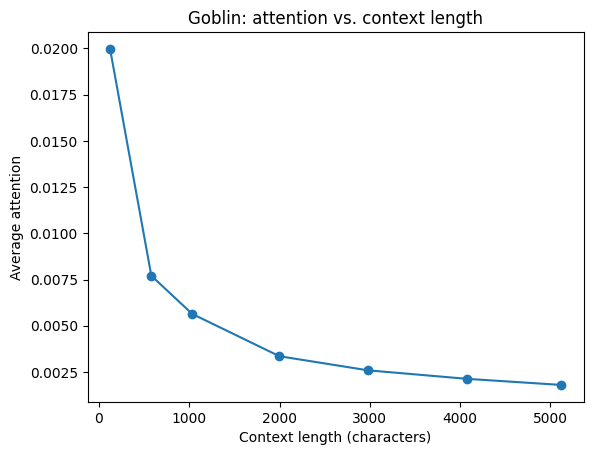

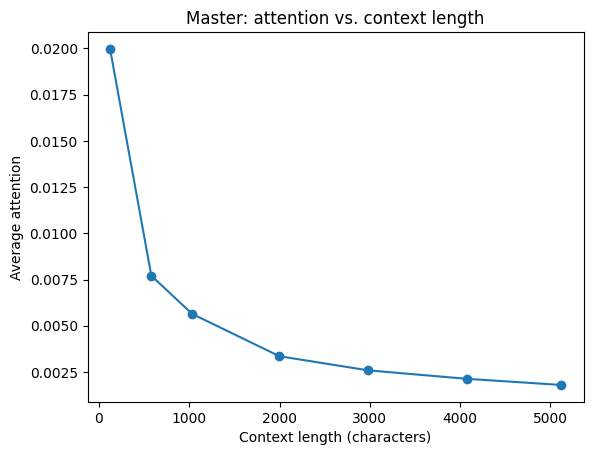

In [11]:
plot_results(plot_dict)